#### 목표
- 네이버 영화리뷰 감성분석을 해보자 (긍정/부정)
- TF-IDF의 개념을 이해하고 사용하자
- 학습 결과를 시각화하여 인사이트를 얻자

#### 용어이해
- 말뭉치(corpus) : 텍스트마이닝, 자연어처리 분야에서 학습을 위해 사용하는 데이터셋
- 문서(documnet) : 말뭉치에서 각 샘플을 지칭하는 단어
- TF(Teram Frequency) : 하나의 문서(documnet)에서 개별 단어들이 등장하는 빈도 수
- DF(Documnn Frequency) :  

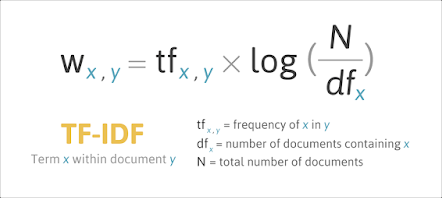

In [8]:
# TF-IDF 사용해보기
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
tf_idf = TfidfVectorizer()
sample_text = ["오늘은 오후에 수업이 3시간입니다. 야호 !",
               "오늘은 비가 오네요",
               "어제도 비가 왔었나?",
               "오전 수업은 무엇을 배웠나요? 오후 수업하고 다른 것을 배웠겠죠?"]

In [6]:
tf_idf.fit(sample_text) # 단어사전 구축
tf_idf.vocabulary_ # 단어사전 확인

{'오늘은': 13,
 '오후에': 16,
 '수업이': 8,
 '3시간입니다': 0,
 '야호': 10,
 '비가': 6,
 '오네요': 12,
 '어제도': 11,
 '왔었나': 17,
 '오전': 14,
 '수업은': 7,
 '무엇을': 3,
 '배웠나요': 5,
 '오후': 15,
 '수업하고': 9,
 '다른': 2,
 '것을': 1,
 '배웠겠죠': 4}

In [9]:
tf_idf.transform(sample_text).toarray() # tf-idf로 수치화

array([[0.46516193, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.46516193, 0.        ,
        0.46516193, 0.        , 0.        , 0.36673901, 0.        ,
        0.        , 0.46516193, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.52640543, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.66767854, 0.52640543, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.48693426, 0.        , 0.        , 0.        ,
        0.        , 0.61761437, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.61761437],
       [0.        , 0.33333333, 0.33333333, 0.33333333, 0.33333333,
        0.33333333, 0.        , 0.33333333, 0.        , 0.33333333,
        0.        , 0.        , 0.        , 0.        , 0.33333333,
        0.33333333, 0.        , 0.        ]])

In [4]:
# 형태소 분석기 -> 클렌징 -> 토큰화/수치화(TF-IDF)

#### 데이터 로딩

In [2]:
import pandas as pd

In [11]:
train = pd.read_csv('data/ratings_train.txt', delimiter="\t")
test = pd.read_csv('data/ratings_test.txt', delimiter="\t")

In [12]:
# 결측치
train.dropna(inplace = True)
test.dropna(inplace = True)

In [13]:
# 긍정 : 1 / 부정 : 0
# 9~10       1~4
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [14]:
# 문제와 답 분리
text_train = train['document']
text_test = test['document']
y_train = train['label']
y_test = test['label']

In [15]:
print(len(text_train))
print(len(text_test))
print(y_train.shape)
print(y_test.shape)

149995
49997
(149995,)
(49997,)


#### 형태소 분석/클렌징/토큰화/수치화 한 번에 하기 (with sklearn)

In [37]:
from konlpy.tag import Okt
import re # 정규표현식
okt = Okt()
p = re.compile("[ㅋㅇㅎㄷ~ㅡ>!.?,0-9a-z]+")  # 정규표현식 패턴

In [5]:
# 사용자 정의 함수
def myTokenizer(text):
    morphs = okt.morphs(text) # 형태소 분석
    result = [] # 형태소 분석과 클렌징이 끝난 토큰들을 담을 리스트
    for token in morphs: # 형태소로 분리된 하나의 리뷰를 반복
        if len(token) < 2: # 한글자 토큰 제외
            continue
        if p.match(token): # 정규표현식에 매칭되는 글자 제거
            continue
        result.append(token)
    return result # 형태소분석과 클렌징이 끝난 리스트를 리턴

In [42]:
naver_movie_tf_idf = TfidfVectorizer(tokenizer=myTokenizer,
                                    stop_words=['영화'],
                                    min_df=10,
                                    max_df= 0.8
                                    ) # 사용자 정의 토크나이저 연결


In [43]:
naver_movie_tf_idf.fit(text_train) # 사용자 정의 함수 호출 및 단어사전 구축

TfidfVectorizer(max_df=0.8, min_df=10, stop_words=['영화'],
                tokenizer=<function myTokenizer at 0x000002868252E7A0>)

In [44]:
len(naver_movie_tf_idf.vocabulary_) # 단어사전 길이 확인

11714

In [45]:
X_train = naver_movie_tf_idf.transform(text_train) # 수치화
X_test = naver_movie_tf_idf.transform(text_test) # 수치화

#### 모델링

In [9]:
from sklearn.linear_model import LogisticRegression

In [47]:
logi = LogisticRegression()
logi.fit(X_train, y_train)

LogisticRegression()

In [48]:
logi.score(X_test, y_test)

0.8295297717863072

In [ ]:
# TF-IDF vectorizer와 Logistic Model 저장

In [49]:
import pickle # 파이썬에 존재하는 모든 데이터 타입을 파일로 저장
with open("./naver_tfidf.pkl", 'wb') as f : # 쓰기 모드로 파일 스트링 오픈
    pickle.dump(naver_movie_tf_idf, f) # 모델객체를 파일에 저장
with open("./naver_logi.pkl", 'wb') as f : # 쓰기 모드로 파일 스트링 오픈
    pickle.dump(logi, f) # 모델객체를 파일에 저장

#### 학습결과 시각화 및 활용

In [11]:
with open('./naver_tfidf.pkl','rb') as f:
    naver_tfidf = pickle.load(f)
with open('./naver_logi.pkl','rb') as f:
    naver_logi = pickle.load(f)

In [13]:
# 단어 사전 추출
vocab = naver_tfidf.vocabulary_
# 학습된 가중치(각 단어별 가중치(
weight = naver_logi.coef_[0]

In [18]:
# 딕셔너리로
df = pd.DataFrame([vocab.keys(), vocab.values()]).T
df.columns = ['단어', 'index']
df = df.set_index('index').sort_index()
df['가중치'] = weight
df =  df.sort_values(by = '가중치').set_index('단어')
df.head()

,가중치
단어,
최악,-9.803006
쓰레기,-6.773315
재미없다,-6.039871
아깝다,-5.873742
지루하다,-5.762469


In [25]:
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

<Axes: xlabel='단어'>

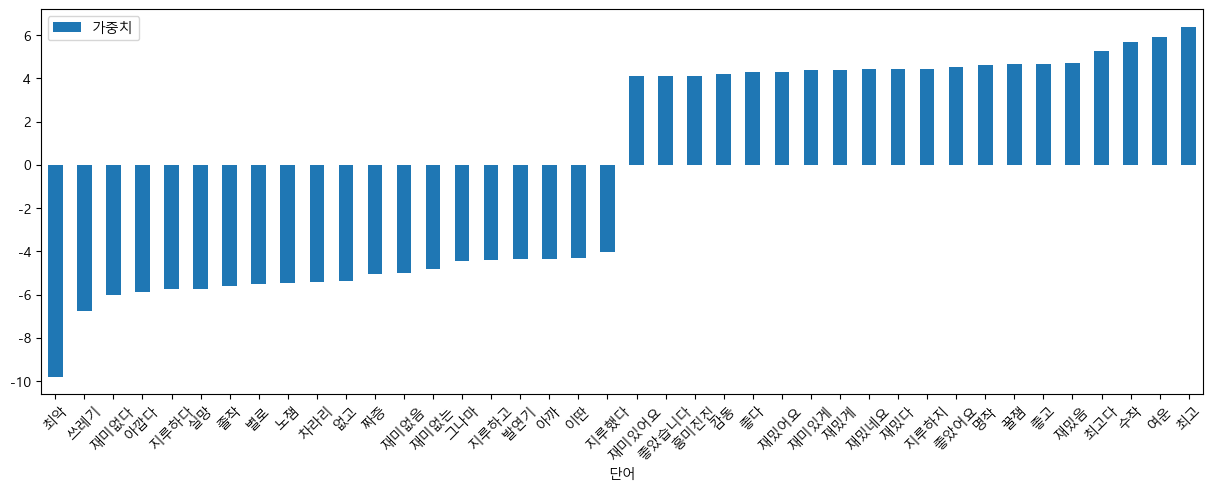

In [29]:
n = df.head(20)
p = df.tail(20)
merge_df = pd.concat([n,p])
merge_df.plot(kind='bar',
             figsize = (15,5),
             rot=45)